DS5110 Project : Formula one race predictions
Yogita Bisht, Suchitra Hole

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sqlalchemy import create_engine
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)


In [64]:

# Connection to SQLite
engine = create_engine(f"sqlite:///D:/f1/f1.db")

# Querying the database

races_query = "SELECT * FROM races"
circuits_query = "SELECT * FROM circuits"
constructor_results_query = "SELECT * FROM constructor_results"
constructor_standings_query = "SELECT * FROM constructor_standings"
constructors_query = "SELECT * FROM constructors"
driver_standings_query = "SELECT * FROM driver_standings"
drivers_query = "SELECT * FROM drivers"
lap_times_query = "SELECT * FROM lap_times"
pit_stops_query = "SELECT * FROM pit_stops"
qualifying_query = "SELECT * FROM qualifying"
results_query = "SELECT * FROM results"
seasons_query = "SELECT * FROM seasons"
status_query = "SELECT * FROM status"

#Data import Method 1:
#converting to pandas dataframes
circuits = pd.read_sql_query(circuits_query, engine)
constructor_results = pd.read_sql_query(constructor_results_query, engine)
constructor_standings = pd.read_sql_query(constructor_standings_query, engine)
constructors_df = pd.read_sql_query(constructors_query, engine)
drivers_df = pd.read_sql_query(drivers_query, engine)
race_df = pd.read_sql_query(races_query, engine)
pit_stops = pd.read_sql_query(pit_stops_query, engine)
qualifying = pd.read_sql_query(qualifying_query, engine)
driver_standings = pd.read_sql_query(driver_standings_query, engine)
status = pd.read_sql_query(status_query, engine)
seasons = pd.read_sql_query(seasons_query, engine)
results_df = pd.read_sql_query(results_query, engine)
lap_times = pd.read_sql_query(lap_times_query, engine)




In [65]:
#Data import Method 2:
#csv to pandas dataframe
circuits_df = pd.read_csv('circuits.csv')
constructor_results_df = pd.read_csv('constructor_results.csv')
constructor_standings_df = pd.read_csv('constructor_standings.csv')
constructors_df = pd.read_csv('constructors.csv')
drivers_df = pd.read_csv('drivers.csv')
race_df = pd.read_csv('races.csv')
pit_stops_df = pd.read_csv('pit_stops.csv')
qualifying_df = pd.read_csv('qualifying.csv')
driver_standings_df = pd.read_csv('driver_standings.csv')
status_df = pd.read_csv('status.csv')
seasons_df = pd.read_csv('seasons.csv')
results_df = pd.read_csv('results.csv')
lap_times_df = pd.read_csv('lap_times.csv')
sprint_results_df = pd.read_csv('sprint_results.csv')

DATA ANALYSIS

In [66]:
#Example: display all columns results from results.csv
pd.get_option("display.max_columns",None)
print(results_df)


       resultId  raceId  driverId  constructorId number  grid position  \
0             1      18         1              1     22     1        1   
1             2      18         2              2      3     5        2   
2             3      18         3              3      7     7        3   
3             4      18         4              4      5    11        4   
4             5      18         5              1     23     3        5   
...         ...     ...       ...            ...    ...   ...      ...   
26514     26520    1132       839            214     31    18       16   
26515     26521    1132       815              9     11     0       17   
26516     26522    1132       855             15     24    14       18   
26517     26523    1132       847            131     63     1       \N   
26518     26524    1132       842            214     10    19       \N   

      positionText  positionOrder  points  laps         time milliseconds  \
0                1              1 

In [67]:
# Starting grid, final position of every driver, constructor and status of each race
print("Driver result of a race")
print(results_df.head())


Driver result of a race
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300       

In [68]:
#Example: perform left join on constructors and results
team = constructors_df.merge(results_df,on='constructorId',how = 'left')
print(team)

       constructorId constructorRef        name nationality  \
0                  1        mclaren     McLaren     British   
1                  1        mclaren     McLaren     British   
2                  1        mclaren     McLaren     British   
3                  1        mclaren     McLaren     British   
4                  1        mclaren     McLaren     British   
...              ...            ...         ...         ...   
26515            215             rb  RB F1 Team     Italian   
26516            215             rb  RB F1 Team     Italian   
26517            215             rb  RB F1 Team     Italian   
26518            215             rb  RB F1 Team     Italian   
26519            215             rb  RB F1 Team     Italian   

                                                    url  resultId  raceId  \
0                  http://en.wikipedia.org/wiki/McLaren       1.0    18.0   
1                  http://en.wikipedia.org/wiki/McLaren       5.0    18.0   
2           

In [69]:
#column extraction from above df teams
best_teams = team[['name','points','raceId']]
#grouping based on team names and counting unique races
best_teams = best_teams.groupby('name')['raceId'].nunique().sort_values(ascending=False).reset_index(name = 'races')
best_teams = best_teams[best_teams['races'] >= 100]
best_teams.head(5)


,name,races
0,Ferrari,1088
1,McLaren,917
2,Williams,831
3,Tyrrell,433
4,Sauber,407


VISUALIZATION

In [70]:
#Visualization 1: AVERAGE CONSTRUCTORS POINTS PER RACE

#calculations
func = lambda x: x.points.sum()/x.raceId.nunique()
data = team[team['name'].isin(best_teams.name)].groupby('name').apply(func).sort_values(ascending=False).reset_index(name = 'points_per_race')
data.head(10)

#plotting
fig = go.Figure(
    data=[go.Bar(x = data.name, y=data['points_per_race'])],
    layout_title_text="Constructor's Points per Race"
    
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='blue', width=2)))
fig.show()

C:\Users\SUCHITRA\AppData\Local\Temp\ipykernel_3428\1577243282.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [71]:
#Visualization 2: DRIVER NATIONALITIES
driver_nationality = drivers_df.groupby('nationality')['nationality'].count().sort_values(ascending = False).reset_index(name = 'number of drivers')
fig = go.Figure(data=[go.Pie(labels=driver_nationality.nationality.head(10), values=driver_nationality['number of drivers'])])
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(
    title="Historical Driver Nationality Distribution")
fig.show()

In [72]:
#Visualization 3: MOST WINS BY DRIVER IN A SEASON

#calculation
driver_position = drivers_df.merge(driver_standings_df,left_on='driverId',right_on='driverId',how = 'left')
driver_position = driver_position.merge(race_df,on = 'raceId',how = 'left')
positions = driver_position[driver_position['position'] == 1].groupby(
    ['surname','year'])['wins'].max().sort_values(ascending=False).reset_index(name = 'Wins')
positions.head(20)
positions.year=pd.to_datetime(positions['year'].astype(int), format='%Y')
positions.year = positions.year.dt.year
positions.rename(columns={'surname':'name'},inplace=True)
positions.Wins = positions.Wins.astype('int64')
positions.head(11)



,name,year,Wins
0,Verstappen,2023,19
1,Verstappen,2022,15
2,Vettel,2013,13
3,Schumacher,2004,13
4,Hamilton,2020,11
5,Hamilton,2019,11
6,Hamilton,2018,11
7,Hamilton,2014,11
8,Schumacher,2002,11
9,Vettel,2011,11


In [73]:
#plotting
fig = px.scatter(positions.head(30), x="year", y="Wins", color="name",
                 title="Most wins by a driver in a single season",size = 'Wins')
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.update_xaxes(showgrid=False)
fig.show()

In the above visualization,Max Verstappen has had the highest wins(19) in year 2023.(HOVER OVER THE GRAPH)

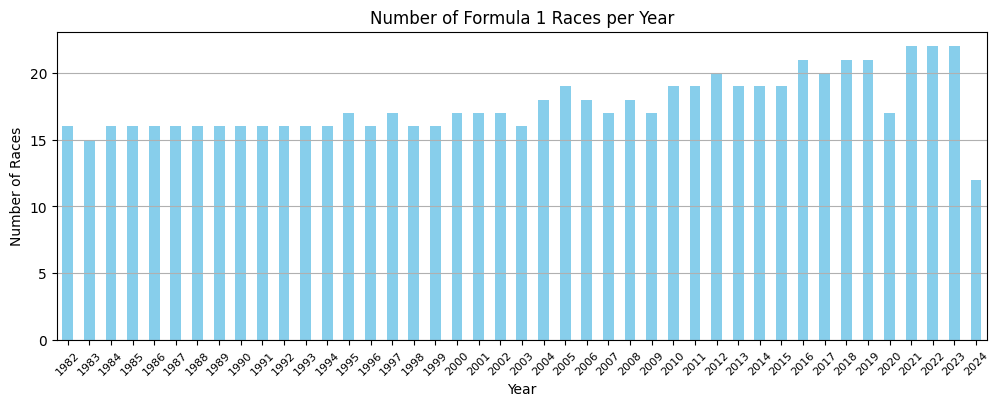

In [74]:
#Visualization 4: NUMBER OF FORMULA 1 RACES PER YEAR
# Group data by 'year' and count the number of races
res_df = results_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']].copy()
race_df = race_df[race_df["year"] >= 1982]
df = pd.merge(race_df, res_df, on='raceId')
races_per_year = df.groupby('year')['raceId'].nunique()

# Create a bar plot
plt.figure(figsize=(12, 4))  # You can adjust the size as per your preference
races_per_year.plot(kind='bar', color='skyblue')

plt.title('Number of Formula 1 Races per Year')
plt.xlabel('Year')
plt.xticks(fontsize = 8)
plt.ylabel('Number of Races')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.grid(axis='y')

# Display the plot
plt.show()

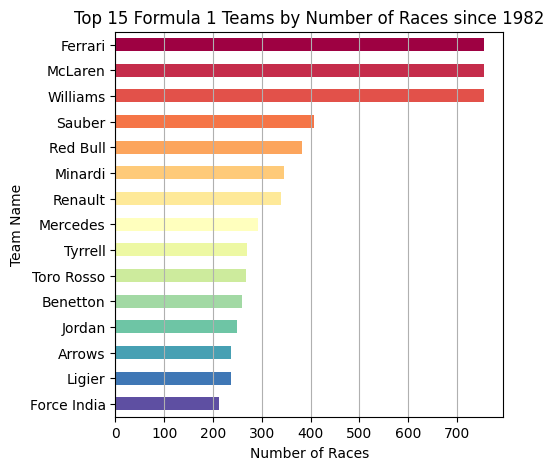

In [75]:
#Visualization 5: TOP 15 F1 TEAMS(CONSTRUCTORS)BY THE NUMBER OF RACES THEY HAVE PARTICIPATED SINCE 1982
# Group data by 'constructorId' and count unique races
races_per_team = df.groupby('constructorId')['raceId'].nunique()

# Create a dictionary to map 'constructorId' to 'name'
constructor_name_dict = pd.Series(constructors_df.name.values, index=constructors_df.constructorId).to_dict()

# Replace 'constructorId' with corresponding 'name' in races_per_team
races_per_team.index = races_per_team.index.map(constructor_name_dict)

# Sort the data from most races to least races and select top 15
races_per_team_sorted = races_per_team.sort_values(ascending=False).head(15)

# Create a bar plot
plt.figure(figsize=(5,5))  # Adjust the figure size to your preference
colors = plt.cm.Spectral(np.linspace(0, 1, len(races_per_team_sorted))) # Using Spectral colormap
races_per_team_sorted.plot(kind='barh', color=colors)

plt.title('Top 15 Formula 1 Teams by Number of Races since 1982')
plt.ylabel('Team Name')
plt.xlabel('Number of Races')
plt.grid(axis='x')

# Reverse the order of the y-axis so the team with most races is on top
plt.gca().invert_yaxis()

# Display the plot
plt.show()

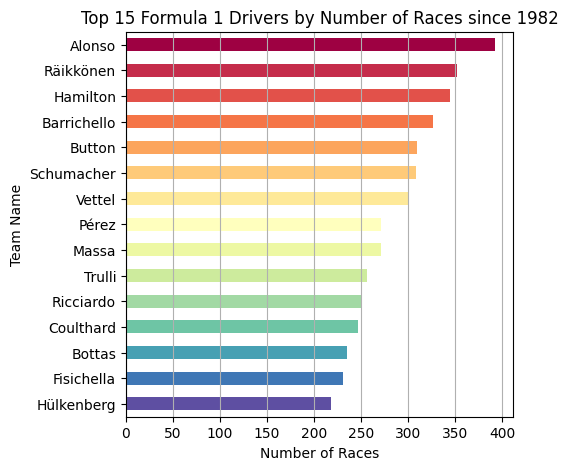

In [76]:
#Visualization 6: TOP 15 F1 TEAMS(DRIVERS)BY THE NUMBER OF RACES THEY HAVE PARTICIPATED SINCE 1982
# Group data by 'driverId' and count unique races
races_per_team = df.groupby('driverId')['raceId'].nunique()

# Create a dictionary to map 'driverId' to 'name'
driver_name_dict = pd.Series(drivers_df.surname.values, index=drivers_df.driverId).to_dict()

# Replace 'driverId' with corresponding 'name' in races_per_team
races_per_team.index = races_per_team.index.map(driver_name_dict)

# Sort the data from most races to least races and select top 15
races_per_team_sorted = races_per_team.sort_values(ascending=False).head(15)

# Create a bar plot
plt.figure(figsize=(5, 5))  # Adjust the figure size to your preference
colors = plt.cm.Spectral(np.linspace(0, 1, len(races_per_team_sorted))) # Using Spectral colormap
races_per_team_sorted.plot(kind='barh', color=colors)

plt.title('Top 15 Formula 1 Drivers by Number of Races since 1982')
plt.ylabel('Team Name')
plt.xlabel('Number of Races')
plt.grid(axis='x')

# Reverse the order of the y-axis so the team with most races is on top
plt.gca().invert_yaxis()

# Display the plot
plt.show()


Data collection for training model
Extracting raceId, year, round, circuitId from races dataframe to train model

In [77]:
race_df = race_df[["raceId", "year", "round", "circuitId"]].copy()
print(race_df)


      raceId  year  round  circuitId
0          1  2009      1          1
1          2  2009      2          2
2          3  2009      3         17
3          4  2009      4          3
4          5  2009      5          4
...      ...   ...    ...        ...
1120    1140  2024     20         32
1121    1141  2024     21         18
1122    1142  2024     22         80
1123    1143  2024     23         78
1124    1144  2024     24         24

[768 rows x 4 columns]


Data Preprocessing

In [78]:
#sorting data by year and using data after year 1982 to have relevant data to newer f1 period
race_df = race_df.sort_values(by=['year', 'round'])
race_df = race_df[race_df["year"] >= 1982]
print(race_df)


      raceId  year  round  circuitId
466      467  1982      1         30
467      468  1982      2         36
468      469  1982      3         43
469      470  1982      4         21
470      471  1982      5         40
...      ...   ...    ...        ...
1120    1140  2024     20         32
1121    1141  2024     21         18
1122    1142  2024     22         80
1123    1143  2024     23         78
1124    1144  2024     24         24

[768 rows x 4 columns]


Extracting raceId, driverId, constructorId, grid (starting postion), positionOrder (finishing position) from results dataframe to train model

In [79]:
res_df = results_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']].copy()
print(res_df)


       raceId  driverId  constructorId  grid  positionOrder
0          18         1              1     1              1
1          18         2              2     5              2
2          18         3              3     7              3
3          18         4              4    11              4
4          18         5              1     3              5
...       ...       ...            ...   ...            ...
26514    1132       839            214    18             16
26515    1132       815              9     0             17
26516    1132       855             15    14             18
26517    1132       847            131     1             19
26518    1132       842            214    19             20

[26519 rows x 5 columns]


In [80]:
#check duplicates in race data
duplicates = race_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")
print(race_df)

Number of duplicate rows: 0
      raceId  year  round  circuitId
466      467  1982      1         30
467      468  1982      2         36
468      469  1982      3         43
469      470  1982      4         21
470      471  1982      5         40
...      ...   ...    ...        ...
1120    1140  2024     20         32
1121    1141  2024     21         18
1122    1142  2024     22         80
1123    1143  2024     23         78
1124    1144  2024     24         24

[768 rows x 4 columns]


Merge race and results data: to have information about the year, the round, and the circuit for a specific race. We checked in above cell that we have no duplicate raceId, so we can proceed with merging the two datasets.

In [81]:
#merged columns: raceId, driverId, constructorId, grid, positionOrder, round, year
df = pd.merge(race_df, res_df, on='raceId')
print(df)


       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  
0                  1  
1                  2  
2                  3  
3                  4  
4                  5

In [82]:
#check if missing values present in any columns
df.dtypes
df.isna().sum()

raceId           0
year             0
round            0
circuitId        0
driverId         0
constructorId    0
grid             0
positionOrder    0
dtype: int64

Feature Engineering: creating and adding a new feature "Top 3 Finish" to specify whether a driver has finished in the top 3 for every race.

In [83]:
# Creating a column for Top 3 Finish
df['Top 3 Finish'] = df['positionOrder'].le(3).astype(int)

# Display the first few rows to confirm the new column
print(df)

# To confirm we have the correct data
numberRace = df["raceId"].nunique()
print(f"Number of unique drivers: {numberRace}")

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  Top 3 Finish  
0                  1             1  
1                  2             1  
2                  3    

IMPORTANT: Following are past performance calculations to predict future race results

Calculating: 1. Top 3 Driver finishes % last year
2. Top 3 Driver finishes % current year till previous race
3. Top 3 Constructors finishes % last year
4. Top 3 Constructors finishes % current year till previous race

Merging: Following 2 columns will be added to our data frame:
1.Driver Top 3 Finish Percentage (Last Year)
2.Constructor Top 3 Finish Percentage (Last Year) 



In [84]:
# Calculating the total number of races and top 3 finishes for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Top_3_Finishes=('Top 3 Finish', 'sum')
).reset_index()

print("Driver annual stats")
print(driver_yearly_stats)
#example reading: row 4:driver with driverId 117 had been in top 3 postitions 4 times over the year 1982 and took part in 16 races.

#percentage calculation for top 3 finishes for each driver in each year
#formula: (top 3 finishes / total races)*100
driver_yearly_stats['Driver Top 3 Finish Percentage (This Year)'] = (driver_yearly_stats['Top_3_Finishes'] / driver_yearly_stats['Total_Races']) * 100

# While calculating percentage for last year, we need to shift the 'year' feature by 1. 
# Shifting the driver percentages to the next year for last year's data
driver_last_year_stats = driver_yearly_stats.copy()
driver_last_year_stats['year'] += 1
driver_last_year_stats = driver_last_year_stats.rename(columns={'Driver Top 3 Finish Percentage (This Year)': 'Driver Top 3 Finish Percentage (Last Year)'})

#appending the new column to data frame
df = pd.merge(df, driver_last_year_stats[['year', 'driverId', 'Driver Top 3 Finish Percentage (Last Year)']], on=['year', 'driverId'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])
#setting filter to 1983 as top 3 finishes column

Driver annual stats
      year  driverId  Total_Races  Top_3_Finishes
0     1982        90            1               0
1     1982        95           13               1
2     1982       105           16               2
3     1982       110           16               1
4     1982       117           16               4
...    ...       ...          ...             ...
1216  2024       852           12               0
1217  2024       855           12               0
1218  2024       857           12               2
1219  2024       858           11               0
1220  2024       860            1               0

[1221 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         36       172              3    18   
468       452  1983      1         36       175      

In [85]:
print(df[df["year"]>=1982])
#Drivers Top 3 Finish Percentage (Last Year) column has NaNs since we are taking values from 1983

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  Top 3 Finish  Driver Top 3 Finish Percentage (Last Year)  
0                  1             1                    

In [86]:
# We need to calculate mean of constructors stats as 1 team has 2 drivers. Calculating for last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Sum_Top_3_Finishes_Last_Year=('Driver Top 3 Finish Percentage (Last Year)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_last_year_stats)

# Calculating the percentage of top 3 finishes for each constructor last year
constructor_last_year_stats['Constructor Top 3 Finish Percentage (Last Year)'] = constructor_last_year_stats["Sum_Top_3_Finishes_Last_Year"]/2

df = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor Top 3 Finish Percentage (Last Year)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round  Sum_Top_3_Finishes_Last_Year
0     1982              1      1                           0.0
1     1982              1      2                           0.0
2     1982              1      3                           0.0
3     1982              1      5                           0.0
4     1982              1      6                           0.0
...    ...            ...    ...                           ...
9098  2024            215      8                           0.0
9099  2024            215      9                           0.0
9100  2024            215     10                           0.0
9101  2024            215     11                           0.0
9102  2024            215     12                           0.0

[9103 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         3

Driver: Percentage of finishing in top 3 for current year till last race

In [87]:
# Function to calculate the top 3 finish percentage before the current round in current year for drivers
def calculate_driver_top_3_percentage_before_round(row, df):
    # Filter for races in the same year, for the same driver, but in earlier rounds
    previous_races = df[(df['year'] == row['year']) & (df['driverId'] == row['driverId']) & (df['round'] < row['round'])]
    if len(previous_races) == 0:
      return pd.NA

    total_races = previous_races['raceId'].nunique()
    top_3_finishes = previous_races['Top 3 Finish'].sum()

    # Calculate the percentage
    return (top_3_finishes / total_races) * 100 if total_races > 0 else pd.NA

# Apply the function to each row in the DataFrame
df['Driver Top 3 Finish Percentage (This Year till last race)'] = df.apply(lambda row: calculate_driver_top_3_percentage_before_round(row, df), axis=1)

Constructor(Team): Percentage of finishing in top 3 for current year till last race

In [88]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor this year
constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Sum_Top_3_Finishes_This_Year=('Driver Top 3 Finish Percentage (This Year till last race)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_this_year_stats)

# Calculating the percentage of top 3 finishes for each constructor this year
constructor_this_year_stats['Constructor Top 3 Finish Percentage (This Year till last race)'] = constructor_this_year_stats["Sum_Top_3_Finishes_This_Year"]/2

df = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor Top 3 Finish Percentage (This Year till last race)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round Sum_Top_3_Finishes_This_Year
0     1982              1      1                            0
1     1982              1      2                          0.0
2     1982              1      3                         50.0
3     1982              1      5                    66.666667
4     1982              1      6                         75.0
...    ...            ...    ...                          ...
9098  2024            215      8                          0.0
9099  2024            215      9                          0.0
9100  2024            215     10                          0.0
9101  2024            215     11                          0.0
9102  2024            215     12                          0.0

[9103 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182 

Past Performance Features: Average Finishing position

Driver: Average finishing position for past year



In [89]:
# Calculating the total number of races and top 3 finishing position for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Avg_position=('positionOrder', 'mean')
).reset_index()

print("Driver annual stats")
print(driver_yearly_stats)

# Calculating the percentage of top 3 finishes for each driver in each year
driver_yearly_stats['Driver Avg position (This Year)'] = driver_yearly_stats['Avg_position']

# Shifting the driver percentages to the next year for last year's data
driver_last_year_stats = driver_yearly_stats.copy()
driver_last_year_stats['year'] += 1
driver_last_year_stats = driver_last_year_stats.rename(columns={'Driver Avg position (This Year)': 'Driver Avg position (Last Year)'})

df = pd.merge(df, driver_last_year_stats[['year', 'driverId', 'Driver Avg position (Last Year)']], on=['year', 'driverId'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Driver annual stats
      year  driverId  Total_Races  Avg_position
0     1982        90            1     30.000000
1     1982        95           13     13.692308
2     1982       105           16      9.000000
3     1982       110           16     14.437500
4     1982       117           16     10.000000
...    ...       ...          ...           ...
1216  2024       852           12     12.250000
1217  2024       855           12     15.333333
1218  2024       857           12      5.750000
1219  2024       858           11     17.272727
1220  2024       860            1      7.000000

[1221 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         36       172              3    18   
468       452  1983      1         36       175              6     3   
469  

Constructor(Team): Average finishing position for past year
Here by constructor average finishing position we mean the average finishing position of both drivers in the team.



In [90]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    sum_position_last_year=('Driver Avg position (Last Year)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_last_year_stats)

# Calculating the percentage of top 3 finishes for each constructor last year
constructor_last_year_stats['Constructor Avg position (Last Year)'] = constructor_last_year_stats["sum_position_last_year"]/2

df = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor Avg position (Last Year)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round  sum_position_last_year
0     1982              1      1                0.000000
1     1982              1      2                0.000000
2     1982              1      3                0.000000
3     1982              1      5                0.000000
4     1982              1      6                0.000000
...    ...            ...    ...                     ...
9098  2024            215      8               25.896104
9099  2024            215      9               25.896104
9100  2024            215     10               25.896104
9101  2024            215     11               25.896104
9102  2024            215     12               25.896104

[9103 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         3

Average finishing position of driver for current year till last race

In [91]:
def calculate_driver_avg_position_before_round(row, df):
    # Filter for races in the same year, for the same driver, but in earlier rounds
    previous_races = df[(df['year'] == row['year']) & (df['driverId'] == row['driverId']) & (df['round'] < row['round'])]
    if len(previous_races) == 0:
      return pd.NA
    # Calculate the total races and sum of positions
    total_races = previous_races['raceId'].nunique()
    positionSum = previous_races['positionOrder'].sum()

    # Calculate average position
    return (positionSum / total_races) if total_races > 0 else pd.NA

# Apply the function to each row in the DataFrame
df['Driver Average Position (This Year till last race)'] = df.apply(lambda row: calculate_driver_avg_position_before_round(row, df), axis=1)

Average finishing position of constructor for current year till last race

In [92]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor this year
constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    sum_Position_Constructor = ('Driver Average Position (This Year till last race)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_this_year_stats)

# Calculating the percentage of top 3 finishes for each constructor this year
constructor_this_year_stats['Constructor Average Position (This Year till last race)'] = constructor_this_year_stats["sum_Position_Constructor"]/2

df = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor Average Position (This Year till last race)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round sum_Position_Constructor
0     1982              1      1                        0
1     1982              1      2                     10.0
2     1982              1      3                     14.5
3     1982              1      5                     12.0
4     1982              1      6                    11.75
...    ...            ...    ...                      ...
9098  2024            215      8                26.857143
9099  2024            215      9                     26.0
9100  2024            215     10                25.555556
9101  2024            215     11                     26.4
9102  2024            215     12                26.090909

[9103 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983     

In [93]:
print(df[(df["year"] == 2024)& (df["round"] > 3) ].tail(30))


       raceId  year  round  circuitId  driverId  constructorId  grid  \
17730    1131  2024     11         70       844              6     6   
17731    1131  2024     11         70       839            214    10   
17732    1131  2024     11         70       840            117    17   
17733    1131  2024     11         70       852            215    14   
17734    1131  2024     11         70       848              3    16   
17735    1131  2024     11         70       822             15    18   
17736    1131  2024     11         70       855             15    20   
17737    1131  2024     11         70         4            117    15   
17738    1131  2024     11         70       858              3    19   
17739    1131  2024     11         70       846              1     2   
17740    1132  2024     12          9         1            131     2   
17741    1132  2024     12          9       830              9     4   
17742    1132  2024     12          9       846              1  

In [94]:
nan_counts = df.isna().sum()
print(nan_counts)

raceId                                                               0
year                                                                 0
round                                                                0
circuitId                                                            0
driverId                                                             0
constructorId                                                        0
grid                                                                 0
positionOrder                                                        0
Top 3 Finish                                                         0
Driver Top 3 Finish Percentage (Last Year)                        3704
Constructor Top 3 Finish Percentage (Last Year)                      0
Driver Top 3 Finish Percentage (This Year till last race)         1221
Constructor Top 3 Finish Percentage (This Year till last race)       0
Driver Avg position (Last Year)                                   3704
Constr

1.The NA in top 3 Finish Percentage Last Year represents that the driver did not participate in F1 last year. 
2.The NA in Driver Top 3 Finish Percentage (This Year till last race) represents that it is the first round of the year (so no previous data) or this is the first round that this driver is participating in that year.

In [95]:
# # Creating a column called Top 3 Finish, where position order is less than or equal to 3
# df['Top 3 Finish'] = df['positionOrder'].le(3).astype(int)
# print(df)

# Creating a column for Top 3 Finish
df['Top 3 Finish'] = df['positionOrder'].le(3).astype(int)

# Display the first few rows to confirm the new column
print(df)

# To confirm we have the correct data
numberRace = df["raceId"].nunique()
print(f"Number of unique drivers: {numberRace}")

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  Top 3 Finish  \
0                  1             1   
1                  2             1   
2                  3 

In [96]:
#drop raceId to prevent data leakage
df_final = df.drop(labels=["raceId"], axis=1)


In [97]:
#final shape
print("Number of rows in total:", df_final.shape[0])


Number of rows in total: 17760


In [98]:
# Total rows where 'year' is not 1982 before dropping NaN values
initial_count = len(df_final[df_final['year'] != 1982])
print(initial_count)


17295


In [99]:
# Drop rows with NaN values
df_final = df_final.dropna()
# Total rows where 'year' is not 1982 after dropping NaN values
final_count = len(df_final[df_final['year'] != 1982])
print(final_count)

13171


In [100]:
#total number of rows dropped
rows_dropped = initial_count - final_count
print(rows_dropped)

4124


In [101]:
#storing data frame with positionOrder feature as a back up before dropping it
df_final_keepPositionOrder = df_final.copy()
#drop Position Order from data frame
df_final = df_final.drop(["positionOrder"], axis = 1)
print(df_final)

       year  round  circuitId  driverId  constructorId  grid  Top 3 Finish  \
493    1983      2         43       187              1    22             1   
494    1983      2         43       182              1    23             1   
495    1983      2         43       163              6     2             1   
496    1983      2         43       172              3     4             0   
497    1983      2         43       176             21    16             0   
...     ...    ...        ...       ...            ...   ...           ...   
17755  2024     12          9       839            214    18             0   
17756  2024     12          9       815              9     0             0   
17757  2024     12          9       855             15    14             0   
17758  2024     12          9       847            131     1             0   
17759  2024     12          9       842            214    19             0   

       Driver Top 3 Finish Percentage (Last Year)  \
493       

Heatmap 

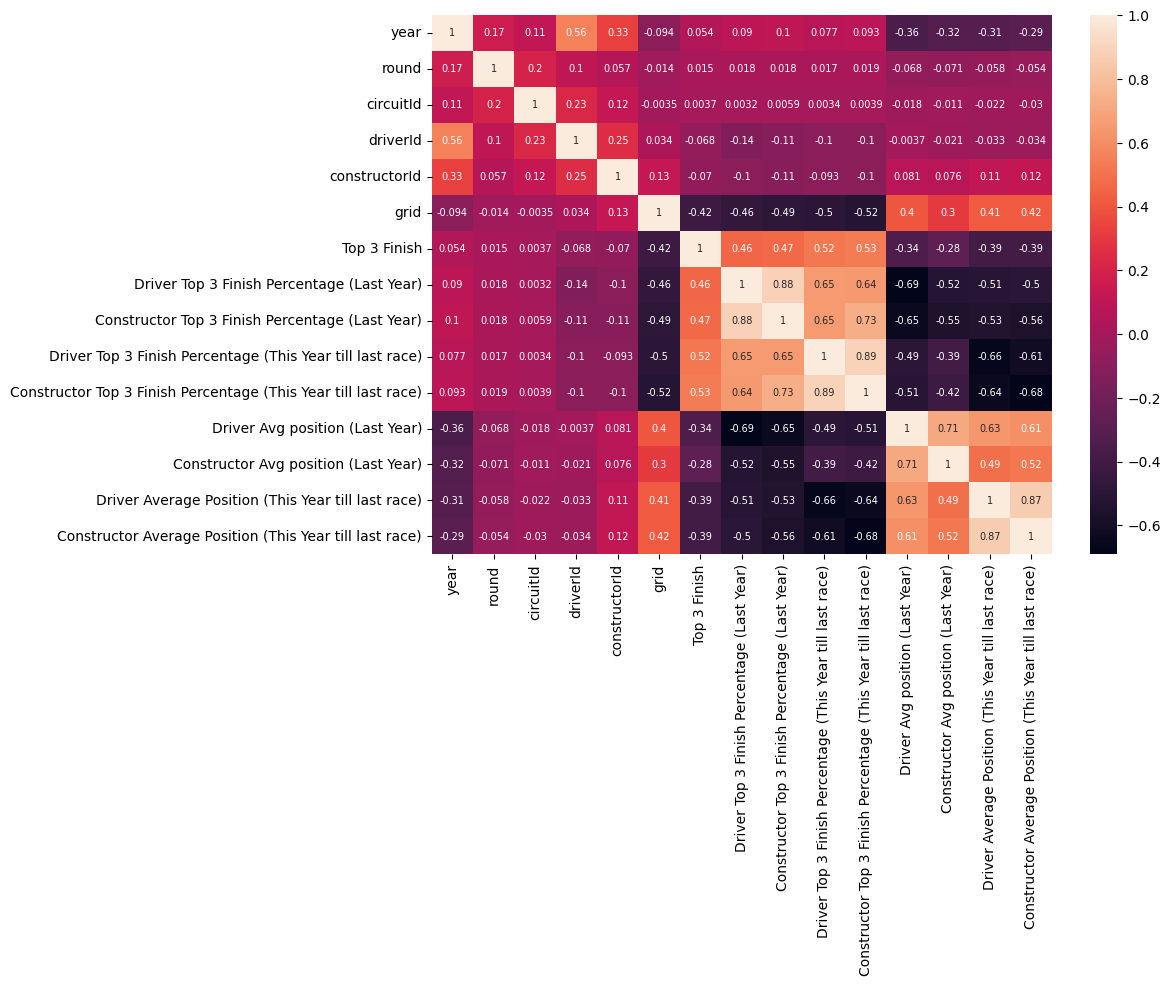

In [102]:
# heatmap
plt.figure(figsize=(10,7))
sns.heatmap(df_final.corr(), annot=True, mask = False, annot_kws={"size": 7})
plt.show()

in the above heatmap, we have strong correlation between 'Driver Top 3 finish percentages' of drivers and 'Constructor Top 3 finish percentages' of constructors with our target variable: 'Top 3 finish', whereas 'grid', 'Driver Average Position', 'Constructor Average Position' have negative correlations with our target variable.

Analyzing the heatmap to identify which features contribute the most to the "Top 3 Finish" target variable

Observations from the Heatmap:
"Top 3 Finish" (target variable) :
Positive values (closer to 1) indicate a strong positive correlation.
Negative values (closer to -1) indicate a strong negative correlation.
Values near 0 indicate little to no correlation.

*positive correlations*
1.Driver Top 3 Finish Percentage (Last Year):
Correlation ~ 0.46 (moderately strong positive).
This suggests that past top 3 finishes by the driver have a significant impact on predicting future top 3 finishes.

2.Constructor Top 3 Finish Percentage (Last Year):
Correlation ~ 0.47 (moderately strong positive).
Performance of the constructor last year is also an important predictor.

3.Driver Top 3 Finish Percentage (This Year till last race):
Correlation ~ 0.53 (strong positive).
Recent driver performance this year is even more influential.

4.Constructor Top 3 Finish Percentage (This Year till last race):
Correlation ~ 0.53 (strong positive).
Similar to driver performance, recent constructor success this year is important.

*Negative correlations*
1.Driver Average Position (Last Year):
Correlation ~ -0.36.

2.Constructor Average Position (Last Year):
Correlation ~ -0.32 (negative correlation).

3.Grid
Correlation ~ -0.42

In [103]:
#tabular format
correlations = df_final.corr()['Top 3 Finish'].sort_values(ascending=False)
print(correlations)

Top 3 Finish                                                      1.000000
Constructor Top 3 Finish Percentage (This Year till last race)    0.531223
Driver Top 3 Finish Percentage (This Year till last race)         0.523979
Constructor Top 3 Finish Percentage (Last Year)                   0.465248
Driver Top 3 Finish Percentage (Last Year)                        0.457875
year                                                              0.053939
round                                                             0.014848
circuitId                                                         0.003733
driverId                                                         -0.068275
constructorId                                                    -0.070372
Constructor Avg position (Last Year)                             -0.276158
Driver Avg position (Last Year)                                  -0.340637
Driver Average Position (This Year till last race)               -0.387256
Constructor Average Posit

One Hot Encoding:for columns: circuitId, driverId, constructorId using pandas get_dummies method

In [104]:
df_final_encoded = pd.get_dummies(df_final, columns=['circuitId', 'driverId', 'constructorId'])


In [105]:
# Create a list of columns excluding the one to append it at end as it is our target variable
cols = [col for col in df_final_encoded.columns if col != 'Top 3 Finish']
print(cols)

['year', 'round', 'grid', 'Driver Top 3 Finish Percentage (Last Year)', 'Constructor Top 3 Finish Percentage (Last Year)', 'Driver Top 3 Finish Percentage (This Year till last race)', 'Constructor Top 3 Finish Percentage (This Year till last race)', 'Driver Avg position (Last Year)', 'Constructor Avg position (Last Year)', 'Driver Average Position (This Year till last race)', 'Constructor Average Position (This Year till last race)', 'circuitId_1', 'circuitId_2', 'circuitId_3', 'circuitId_4', 'circuitId_5', 'circuitId_6', 'circuitId_7', 'circuitId_8', 'circuitId_9', 'circuitId_10', 'circuitId_11', 'circuitId_12', 'circuitId_13', 'circuitId_14', 'circuitId_15', 'circuitId_16', 'circuitId_17', 'circuitId_18', 'circuitId_19', 'circuitId_20', 'circuitId_21', 'circuitId_22', 'circuitId_24', 'circuitId_25', 'circuitId_26', 'circuitId_27', 'circuitId_28', 'circuitId_29', 'circuitId_30', 'circuitId_31', 'circuitId_32', 'circuitId_33', 'circuitId_34', 'circuitId_35', 'circuitId_37', 'circuitId_

In [106]:
# Append here to the end of the DataFrame
df_final_encoded = df_final_encoded[cols + ['Top 3 Finish']]

In [107]:
cols = [col for col in df_final_encoded.columns]
print(cols)

['year', 'round', 'grid', 'Driver Top 3 Finish Percentage (Last Year)', 'Constructor Top 3 Finish Percentage (Last Year)', 'Driver Top 3 Finish Percentage (This Year till last race)', 'Constructor Top 3 Finish Percentage (This Year till last race)', 'Driver Avg position (Last Year)', 'Constructor Avg position (Last Year)', 'Driver Average Position (This Year till last race)', 'Constructor Average Position (This Year till last race)', 'circuitId_1', 'circuitId_2', 'circuitId_3', 'circuitId_4', 'circuitId_5', 'circuitId_6', 'circuitId_7', 'circuitId_8', 'circuitId_9', 'circuitId_10', 'circuitId_11', 'circuitId_12', 'circuitId_13', 'circuitId_14', 'circuitId_15', 'circuitId_16', 'circuitId_17', 'circuitId_18', 'circuitId_19', 'circuitId_20', 'circuitId_21', 'circuitId_22', 'circuitId_24', 'circuitId_25', 'circuitId_26', 'circuitId_27', 'circuitId_28', 'circuitId_29', 'circuitId_30', 'circuitId_31', 'circuitId_32', 'circuitId_33', 'circuitId_34', 'circuitId_35', 'circuitId_37', 'circuitId_

In [108]:
print(df_final_encoded)
print(df_final_encoded.shape)


       year  round  grid  Driver Top 3 Finish Percentage (Last Year)  \
493    1983      2    22                                   33.333333   
494    1983      2    23                                   21.428571   
495    1983      2     2                                   25.000000   
496    1983      2     4                                    6.666667   
497    1983      2    16                                    0.000000   
...     ...    ...   ...                                         ...   
17755  2024     12    18                                    4.545455   
17756  2024     12     0                                   40.909091   
17757  2024     12    14                                    0.000000   
17758  2024     12     1                                    9.090909   
17759  2024     12    19                                    4.545455   

       Constructor Top 3 Finish Percentage (Last Year)  \
493                                          27.380952   
494                

In [109]:
#display any row to see structure of data frame
print(df_final_encoded.iloc[58])


year                                                   1983
round                                                     4
grid                                                     15
Driver Top 3 Finish Percentage (Last Year)         7.692308
Constructor Top 3 Finish Percentage (Last Year)    7.179487
                                                     ...   
constructorId_211                                     False
constructorId_213                                     False
constructorId_214                                     False
constructorId_215                                     False
Top 3 Finish                                              0
Name: 561, Length: 316, dtype: object


In [110]:
df_final_encoded.head(25)

,year,round,grid,Driver Top 3 Finish Percentage (Last Year),Constructor Top 3 Finish Percentage (Last Year),Driver Top 3 Finish Percentage (This Year till last race),Constructor Top 3 Finish Percentage (This Year till last race),Driver Avg position (Last Year),Constructor Avg position (Last Year),Driver Average Position (This Year till last race),...,constructorId_206,constructorId_207,constructorId_208,constructorId_209,constructorId_210,constructorId_211,constructorId_213,constructorId_214,constructorId_215,Top 3 Finish
493,1983,2,22,33.333333,27.380952,0.0,50.0,8.333333,8.845238,19.0,...,False,False,False,False,False,False,False,False,False,1
494,1983,2,23,21.428571,27.380952,100.0,50.0,9.357143,8.845238,2.0,...,False,False,False,False,False,False,False,False,False,1
495,1983,2,2,25.000000,31.250000,0.0,0.0,14.062500,11.593750,9.0,...,False,False,False,False,False,False,False,False,False,1
496,1983,2,4,6.666667,23.333333,100.0,50.0,16.466667,11.233333,3.0,...,False,False,False,False,False,False,False,False,False,0
497,1983,2,16,0.000000,0.000000,0.0,0.0,10.166667,5.083333,5.0,...,False,False,False,False,False,False,False,False,False,0
499,1983,2,26,0.000000,0.000000,0.0,0.0,20.866667,20.433333,20.0,...,False,False,False,False,False,False,False,False,False,0
501,1983,2,7,12.500000,6.250000,0.0,0.0,9.000000,4.500000,26.0,...,False,False,False,False,False,False,False,False,False,0
502,1983,2,11,20.000000,16.666667,0.0,50.0,14.666667,14.366667,23.0,...,False,False,False,False,False,False,False,False,False,0
503,1983,2,8,25.000000,22.500000,0.0,0.0,10.000000,11.900000,6.0,...,False,False,False,False,False,False,False,False,False,0
504,1983,2,13,7.692308,7.179487,0.0,0.0,13.692308,12.146154,11.0,...,False,False,False,False,False,False,False,False,False,0


Data Modelling 

Model 1: Predicting F1 podiums without qualfying data:
Trianing data: year 1983 - 2008

Validation data: year 2009 - 2016

Test data: year 2017 - 2023

In [111]:
#features taken to train model: year, round, circuit, constructor, race,  percentages of finishing in top 3 for the past year for drivers,  percentages of finishing in top 3 for the past year for constructors
# drop features detected in heatmap that dont correlate to top 3 finishes target variable
df_new = df_final_encoded.drop(["grid", "Driver Top 3 Finish Percentage (This Year till last race)", "Constructor Top 3 Finish Percentage (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)"], axis = 1) 

In [112]:
#splitting data into training, validation and testing data based on years
train_df = df_new[(df_new["year"] >= 1983) & (df_new["year"] <= 2008)]
val_df = df_new[(df_new["year"] >= 2009) & (df_new["year"] <= 2016)]
test_df = df_new[(df_new["year"] >= 2017) & (df_new["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

This code performs hyperparameter tuning, evaluation, and ROC curve plotting for three machine learning models:

Logistic Regression
Random Forest Classifier
Decision Tree Classifier

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 0.001, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.7933

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.8561

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.6070

Model: LogisticRegression, File: LogisticRegression_model_V1.joblib, Test AUC-ROC: 0.7933, Test Accuracy: 0.8178
Model: RandomForestClassifier, File: RandomForestClassifier_model_V1.joblib, Test AUC-ROC: 0.8561, Test Accuracy: 0.8187
Model: DecisionTreeClassifier, File: DecisionTreeClassifier_model_V1.joblib, Test AUC-ROC: 0.6070, Test Accuracy: 0.8217


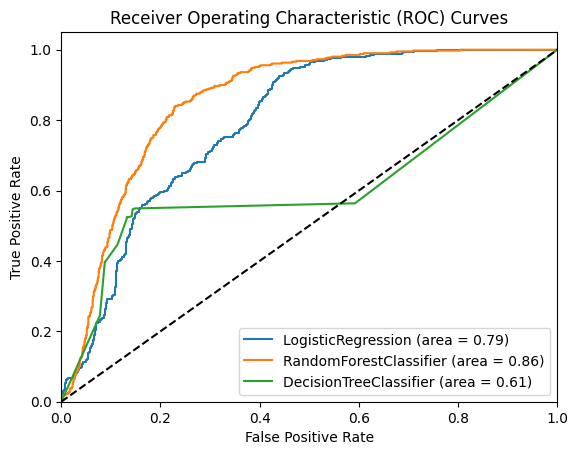

In [113]:
# #In this scenario, there is an imbalance between the two classes:
# Class 1: Drivers finishing in the top 3 (only 3 drivers).
# Class 0: Drivers not finishing in the top 3 (more drivers).
# This imbalance means that the majority of data belongs to the "not in top 3" class.
# # Accuracy as a metric would measure the percentage of correct prediction.
# # In class-imbalanced datasets, accuracy can be misleading because predicting the majority class(drivers not in top 3) often results in a high accuracy rate.
# # Example: If the model always predicts "not in top 3," accuracy might be 85%, but the model will fail to identify any driver in the top 3, which is our goal.
#Therefore, we will use AUC-ROC Score will measure how well our model separates 2 classes


# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]}, #C:Controls regularization strength.
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]}, #n_estimators: Number of trees in the forest
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]} #max_depth: Maximum depth of trees for Decision Tree and Random Forest.
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

# Ignore convergence and future warnings

simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val) #returns the probability estimates for each class, class 0 and 1
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC, which measures the model’s ability to distinguish between the two classes
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V1.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

Class Imbalance: The dataset is imbalanced, where most drivers do not finish in the top 3.
AUC-ROC Score: Measures the model's ability to distinguish between classes (drivers in the top 3 vs. not in the top 3). A higher AUC means better performance.

Therefore, we will use AUC-ROC Score will measure how well our model separates 2 classes

Model 2: Predicting F1 podiums without qualifying data and adding features


In [114]:
#adding feature: 1.Percentages of finishing in top 3 in drivers 2.Percentages of finishing in constructors
df_new = df_final_encoded.drop(["grid", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)"], axis = 1)
train_df = df_new[(df_new["year"] >= 1983) & (df_new["year"] <= 2008)]
val_df = df_new[(df_new["year"] >= 2009) & (df_new["year"] <= 2016)]
test_df = df_new[(df_new["year"] >= 2017) & (df_new["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 10, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9032

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 10, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.8795

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.5362

Model: LogisticRegression, File: LogisticRegression_model_V1.joblib, Test AUC-ROC: 0.9032, Test Accuracy: 0.8641
Model: RandomForestClassifier, File: RandomForestClassifier_model_V1.joblib, Test AUC-ROC: 0.8795, Test Accuracy: 0.8315
Model: DecisionTreeClassifier, File: DecisionTreeClassifier_model_V1.joblib, Test AUC-ROC: 0.5362, Test Accuracy: 0.8118


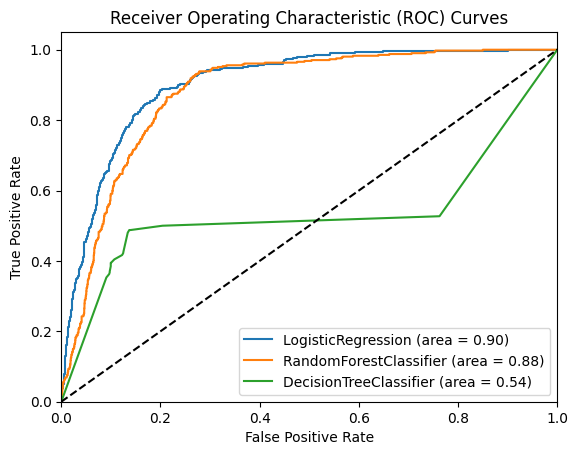

In [115]:
#Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

# Ignore convergence and future warnings
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V1.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

Model 3: Predicting F1 podiums with qualifying data


In [116]:
df_with_qualifying = df_final_encoded
train_df = df_with_qualifying[(df_with_qualifying["year"] >= 1983) & (df_with_qualifying["year"] <= 2008)]
val_df = df_with_qualifying[(df_with_qualifying["year"] >= 2009) & (df_with_qualifying["year"] <= 2016)]
test_df = df_with_qualifying[(df_with_qualifying["year"] >= 2017) & (df_with_qualifying["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 10, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9220

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 30, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.9167

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.7125

Model: LogisticRegression, File: LogisticRegression_model_V1.joblib, Test AUC-ROC: 0.9220, Test Accuracy: 0.8791
Model: RandomForestClassifier, File: RandomForestClassifier_model_V1.joblib, Test AUC-ROC: 0.9167, Test Accuracy: 0.8714
Model: DecisionTreeClassifier, File: DecisionTreeClassifier_model_V1.joblib, Test AUC-ROC: 0.7125, Test Accuracy: 0.8440


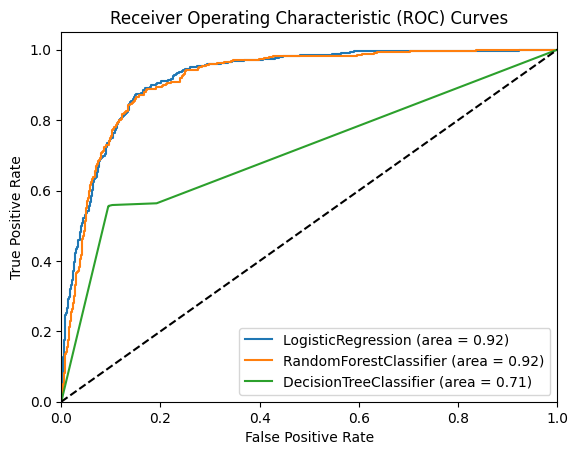

In [117]:
#Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

# Ignore convergence and future warnings
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V1.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


Model Interpretation

In [118]:
max_depth = 2 # Adjust this value to control the number of levels shown

dt_model = joblib.load("DecisionTreeClassifier_model_V1.joblib")

# Set the size of the plot
plt.figure(figsize=(70, 20))


dt_feature_importances = dt_model.feature_importances_

# Create a DataFrame from the feature names and their importances
dt_importances_df = pd.DataFrame({
    'Feature': train_df.columns[:-1],  # Ensure this matches your feature set
    'Importance': dt_feature_importances
})

# Sort the DataFrame by the importances
dt_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the sorted DataFrame
print(dt_importances_df.head(10))

                                              Feature  Importance
5   Driver Top 3 Finish Percentage (This Year till...    0.276352
2                                                grid    0.112342
9   Driver Average Position (This Year till last r...    0.077744
10  Constructor Average Position (This Year till l...    0.072488
6   Constructor Top 3 Finish Percentage (This Year...    0.054995
4     Constructor Top 3 Finish Percentage (Last Year)    0.053466
1                                               round    0.047024
7                     Driver Avg position (Last Year)    0.029446
0                                                year    0.024211
3          Driver Top 3 Finish Percentage (Last Year)    0.021446


<Figure size 7000x2000 with 0 Axes>

In [119]:
model = joblib.load("RandomForestClassifier_model_V1.joblib")
importances = model.feature_importances_

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': df_with_qualifying.columns[:-1], 'Importance': importances})

# Sort the DataFrame
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
print(importances_df.head(10))

print(model.get_params(deep = True))

                                              Feature  Importance
2                                                grid    0.109818
5   Driver Top 3 Finish Percentage (This Year till...    0.103322
6   Constructor Top 3 Finish Percentage (This Year...    0.093360
9   Driver Average Position (This Year till last r...    0.085857
10  Constructor Average Position (This Year till l...    0.080808
3          Driver Top 3 Finish Percentage (Last Year)    0.054307
1                                               round    0.049677
4     Constructor Top 3 Finish Percentage (Last Year)    0.048401
7                     Driver Avg position (Last Year)    0.046987
8                Constructor Avg position (Last Year)    0.035372
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.

Optimal Threshold for F1 Score: 0.359


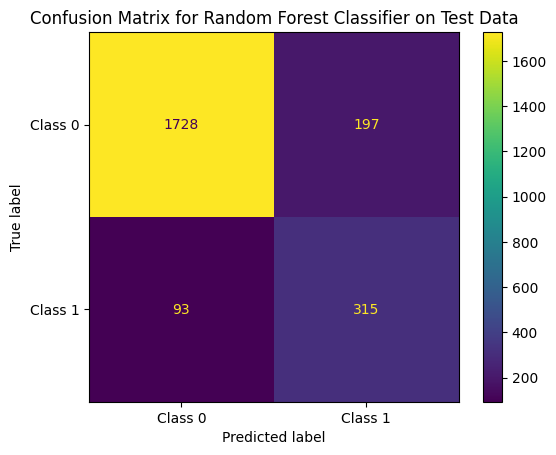

Accuracy of the model: 0.876
F1 Score of the model: 0.685


['RandomForestClassifier_model_V4_with_threshold.joblib']

In [120]:
from sklearn.metrics import precision_recall_curve, f1_score, ConfusionMatrixDisplay
# Load the model
model = joblib.load("RandomForestClassifier_model_V1.joblib")

# Predict probabilities on new data
data_prob = model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, data_prob)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)

# Find the optimal threshold on f1 since using the default threshold of 0.5 can often lead to misleading results
optimal_idx = np.nanargmax(f1_scores)  # Using nanargmax to ignore NaN values
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold for F1 Score: {optimal_threshold:.3f}")

# Apply the new threshold to make class predictions
pred_test = (data_prob >= optimal_threshold).astype(int)

# Display the Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, display_labels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, pred_test)
print(f"Accuracy of the model: {accuracy:.3f}")

# Calculate and print the F1 score
f1 = f1_score(y_test, pred_test)
print(f"F1 Score of the model: {f1:.3f}")

# Create a dictionary to hold the model and the threshold
model_data = {
    "model": model,
    "threshold": optimal_threshold
}

# Save the dictionary
model_filename = "RandomForestClassifier_model_V4_with_threshold.joblib"
joblib.dump(model_data, model_filename)

#Precision tells you how many of the instances classified as Class 1 are actually correct.
#Recall tells you how many of the actual Class 1 instances were correctly classified.
#F1 score is the harmonic mean of precision and recall, providing a balanced measure of model performance.

Confusion matrix analysis:
True Negatives (TN): 1728
This represents the number of times the model correctly predicted Class 0 (i.e., drivers who did not finish in the top 3).

False Positives (FP): 197
These are the times the model incorrectly predicted Class 1 (drivers in the top 3) when they were actually Class 0.

False Negatives (FN): 93
These are the times the model incorrectly predicted Class 0 when the actual class was Class 1 (i.e., it missed predicting the top 3 finishers).

True Positives (TP): 315
This is the number of times the model correctly predicted Class 1 (drivers who finished in the top 3).

Readings:
The model has a high accuracy (87.6%), but its performance on Class 1 (drivers in the top 3) could be improved, as seen from the 93 False Negatives and 197 False Positives.
The Precision for Class 1 is 0.615, meaning that out of all instances predicted as top 3, 61.5% were actually correct.
The Recall for Class 1 is 0.773, indicating that 77.3% of the actual top 3 finishers were identified by the model.



F1 podium prediction example: 2023 Spanish Grand Prix (Round 7)


In [121]:


round = 7

# Load the model and threshold
model_data = joblib.load("RandomForestClassifier_model_V4_with_threshold.joblib")
model = model_data["model"]
optimal_threshold = model_data["threshold"]

# Filter the DataFrame for the year 2023 and round 7 (Spanish Grand Prix)
df_2023 = df_with_qualifying[(df_with_qualifying["year"] == 2023) & (df_with_qualifying["round"] == round)]

# Prepare the feature matrix for prediction
X_2023 = df_2023[df_2023.columns.tolist()[:-1]].values

# Compute probabilities using the model
probabilities = model.predict_proba(X_2023)

# Apply the threshold to make class predictions
pred_test = (probabilities[:, 1] >= optimal_threshold).astype(int)  # Assuming the second column represents the probability of top 3 finish

# Selecting relevant columns and filtering for year 2023 and round 7
df_predict2023 = df_final[["year", "round", "driverId", "constructorId", "grid", "Top 3 Finish"]]
df_predict2023 = df_predict2023[(df_predict2023["year"] == 2023) & (df_predict2023["round"] == round)]



# Create a dictionary to map 'driverId' to 'surname'
driver_name_dict = pd.Series(drivers_df.surname.values, index=drivers_df.driverId).to_dict()

# Replace 'driverId' with corresponding 'surname' in df_predict2023
df_predict2023['driverId'] = df_predict2023['driverId'].map(driver_name_dict)

# Append the predictions to the DataFrame
df_predict2023['Top_3_Finish_Prediction'] = pred_test


# Create a dictionary to map 'constructorId' to 'name'
constructor_name_dict = pd.Series(constructors_df.name.values, index=constructors_df.constructorId).to_dict()

# Replace 'constructorId' with corresponding 'name' in df_predict2023
df_predict2023['constructorId'] = df_predict2023['constructorId'].map(constructor_name_dict)

# Append the predictions to the DataFrame
df_predict2023['Top_3_Finish_Prediction'] = pred_test


# Print the DataFrame with predictions
print(df_predict2023)

       year  round    driverId   constructorId  grid  Top 3 Finish  \
17201  2023      7  Verstappen        Red Bull     1             1   
17202  2023      7    Hamilton        Mercedes     4             1   
17203  2023      7     Russell        Mercedes    12             1   
17204  2023      7       Pérez        Red Bull    11             0   
17205  2023      7       Sainz         Ferrari     2             0   
17206  2023      7      Stroll    Aston Martin     5             0   
17207  2023      7      Alonso    Aston Martin     8             0   
17208  2023      7        Ocon  Alpine F1 Team     6             0   
17209  2023      7        Zhou      Alfa Romeo    13             0   
17210  2023      7       Gasly  Alpine F1 Team    10             0   
17211  2023      7     Leclerc         Ferrari    19             0   
17212  2023      7     Tsunoda      AlphaTauri    15             0   
17214  2023      7    de Vries      AlphaTauri    14             0   
17215  2023      7  

F1 podium prediction example: 2024 Italian Grand Prix (Round 7)


In [122]:


round = 7

# Load the model and threshold
model_data = joblib.load("RandomForestClassifier_model_V4_with_threshold.joblib")
model = model_data["model"]
optimal_threshold = model_data["threshold"]

# Filter the DataFrame for the year 2023 and round 7 (Spanish Grand Prix)
df_2024 = df_with_qualifying[(df_with_qualifying["year"] == 2024) & (df_with_qualifying["round"] == round)]

# Prepare the feature matrix for prediction
X_2024 = df_2024[df_2024.columns.tolist()[:-1]].values

# Compute probabilities using the model
probabilities = model.predict_proba(X_2024)

# Apply the threshold to make class predictions
pred_test = (probabilities[:, 1] >= optimal_threshold).astype(int)  # Assuming the second column represents the probability of top 3 finish

# Selecting relevant columns and filtering for year 2024 and round 7
df_predict2024 = df_final[["year", "round", "driverId", "constructorId", "grid", "Top 3 Finish"]]
df_predict2024 = df_predict2024[(df_predict2024["year"] == 2024) & (df_predict2024["round"] == round)]



# Create a dictionary to map 'driverId' to 'surname'
driver_name_dict = pd.Series(drivers_df.surname.values, index=drivers_df.driverId).to_dict()

# Replace 'driverId' with corresponding 'surname' in df_predict2023
df_predict2024['driverId'] = df_predict2024['driverId'].map(driver_name_dict)

# Append the predictions to the DataFrame
df_predict2024['Top_3_Finish_Prediction'] = pred_test


# Create a dictionary to map 'constructorId' to 'name'
constructor_name_dict = pd.Series(constructors_df.name.values, index=constructors_df.constructorId).to_dict()

# Replace 'constructorId' with corresponding 'name' in df_predict2023
df_predict2024['constructorId'] = df_predict2024['constructorId'].map(constructor_name_dict)

# Append the predictions to the DataFrame
df_predict2024['Top_3_Finish_Prediction'] = pred_test


# Print the DataFrame with predictions
print(df_predict2024)

       year  round    driverId   constructorId  grid  Top 3 Finish  \
17640  2024      7  Verstappen        Red Bull     1             1   
17641  2024      7      Norris         McLaren     2             1   
17642  2024      7     Leclerc         Ferrari     3             1   
17643  2024      7     Piastri         McLaren     5             0   
17644  2024      7       Sainz         Ferrari     4             0   
17645  2024      7    Hamilton        Mercedes     8             0   
17646  2024      7     Russell        Mercedes     6             0   
17647  2024      7       Pérez        Red Bull    11             0   
17648  2024      7      Stroll    Aston Martin    13             0   
17649  2024      7     Tsunoda      RB F1 Team     7             0   
17650  2024      7  Hülkenberg    Haas F1 Team    10             0   
17651  2024      7   Magnussen    Haas F1 Team    18             0   
17652  2024      7   Ricciardo      RB F1 Team     9             0   
17653  2024      7  